In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


In [9]:
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3), nn.ReLU(),
            nn.Conv2d(16, 32, 3), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32*12*12, 100), nn.ReLU(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        return self.net(x)

class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 8, 3), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(8*13*13, 10)
        )

    def forward(self, x):
        return self.net(x)


In [10]:
def train_teacher(teacher, loader, epochs=3):
    teacher.train()
    opt = optim.Adam(teacher.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        total_loss = 0.0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = loss_fn(teacher(x), y)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        print(f"[Teacher] Epoch {epoch+1}, Loss: {total_loss / len(loader):.4f}")


In [11]:
def distill(student, teacher, loader, alpha=0.5, T=3.0, epochs=5):
    teacher.eval()
    student.train()
    opt = optim.Adam(student.parameters(), lr=0.001)
    ce = nn.CrossEntropyLoss()
    losses = []

    for epoch in range(epochs):
        total_loss = 0.0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                t_out = teacher(x)
            s_out = student(x)

            loss = alpha * ce(s_out, y) + (1 - alpha) * nn.KLDivLoss(reduction='batchmean')(
                torch.log_softmax(s_out / T, dim=1),
                torch.softmax(t_out / T, dim=1)
            )
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item()
        avg = total_loss / len(loader)
        print(f"[KD] Epoch {epoch+1}, Loss: {avg:.4f}")
        losses.append(avg)

    plt.plot(losses, marker='o')
    plt.title("Loss - Knowledge Distillation")
    plt.xlabel("Époques")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()


In [12]:
def compare_outputs(teacher, student, loader):
    teacher.eval()
    student.eval()
    x, _ = next(iter(loader))
    x = x.to(device)[:1]
    with torch.no_grad():
        t = torch.softmax(teacher(x), dim=1).cpu().numpy()[0]
        s = torch.softmax(student(x), dim=1).cpu().numpy()[0]
    plt.bar(range(10), t, alpha=0.7, label="Prof")
    plt.bar(range(10), s, alpha=0.7, label="Étudiant")
    plt.legend()
    plt.title("Sorties : Prof vs Étudiant")
    plt.grid(True)
    plt.show()


[Teacher] Epoch 1, Loss: 0.1670
[Teacher] Epoch 2, Loss: 0.0481
[Teacher] Epoch 3, Loss: 0.0319
[KD] Epoch 1, Loss: 0.3112
[KD] Epoch 2, Loss: 0.1067
[KD] Epoch 3, Loss: 0.0758
[KD] Epoch 4, Loss: 0.0631
[KD] Epoch 5, Loss: 0.0560


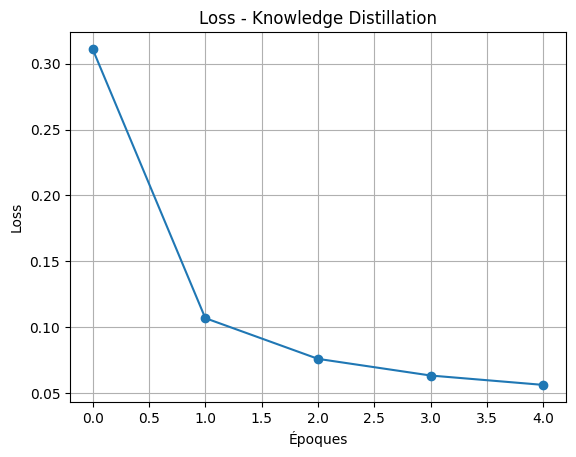

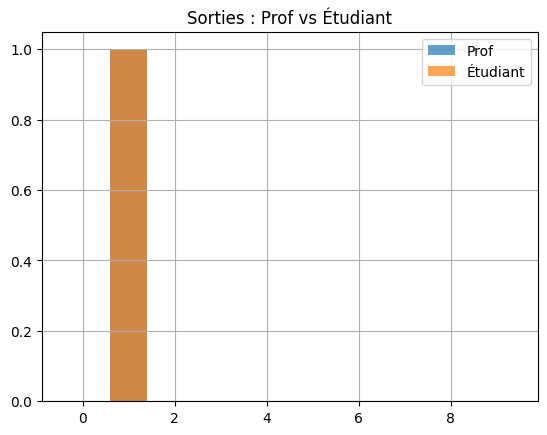

In [13]:
teacher = Teacher().to(device)
student = Student().to(device)

train_teacher(teacher, trainloader)
distill(student, teacher, trainloader)
compare_outputs(teacher, student, trainloader)
